In [1]:
import os
import numpy as np
from bct import modularity

from clique import Clique
from itertools import combinations
import matplotlib.pylab as plt

In [2]:
def load_group_files(base_url, group_path):
    path = '{}/{}/'.format(base_url, group_path)
    file_names = sorted(os.listdir(path))
    files = ['{}{}'.format(path, elem) for elem in file_names]
    return files

def load_matrix_subjects(base_url, group_path):
    group_files = load_group_files(base_url, group_path)
    return _load_matrix_subject_with_files(group_files)

def _load_matrix_subject_with_files(files):
    subjects = []
    for file in files:
        mat = np.loadtxt(file, delimiter=' ')
        np.fill_diagonal(mat, 0)
        subjects.append(mat)
    return np.array(subjects)

In [3]:
def measure_edge_weight(aff, mat, edge_combo):
    inter_weight = 0
    intra_weight = 0

    intra_count = 0
    inter_count = 0

    for e in edge_combo:
        if aff[e[0]] == aff[e[1]]:
            intra_weight += mat[e]
            if mat[e] != 0:
                intra_count += 1
        else:
            inter_weight += mat[e]
            if mat[e] != 0:
                inter_count += 1

    inter_ratio = inter_weight / np.sum(mat) * 2
    intra_ratio = intra_weight / np.sum(mat) * 2

    print(f'# of inter-edges: {inter_count}; # of intra-edges: {intra_count}')
    print(f'inter-edge ratio: {inter_ratio:.4f}; intra-edge ratio: {intra_ratio:.4f}')
    print(f'total inter-edge weight: {inter_weight:.4f}; total intra-edge weight: {intra_weight:.4f}')
    # return inter_ratio, intra_ratio

In [4]:
data_type = 'correlation'
datasets = ['adolescents', 'children', 'eyesclosed', 'male', 'female', 'complete_abide']

n_nodes = 116
edge_combo = list(combinations(range(n_nodes), 2))

In [5]:
idx = 5

In [6]:
dataset = datasets[idx]

diff_mat = np.loadtxt(f"../abide_datasets/{data_type}_diff_mat/{dataset}/td_asd_diff_mat_whole_dataset.txt")

td_subjects = load_matrix_subjects(f'../abide_datasets/{data_type}/{dataset}', 'td')
asd_subjects = load_matrix_subjects(f'../abide_datasets/{data_type}/{dataset}', 'asd')

td_mean = np.mean(td_subjects, axis=0)
asd_mean = np.mean(asd_subjects, axis=0)

td_positive_mean = td_mean * (td_mean > 0)
td_negative_mean = td_mean * (td_mean < 0)
asd_positive_mean = asd_mean * (asd_mean > 0)
asd_negative_mean = asd_mean * (asd_mean < 0)

td_asd_edges = Clique.create_cliques(edge_combo, td_mean - asd_mean)
sorted_edge_indices = np.flip(np.argsort(td_asd_edges))

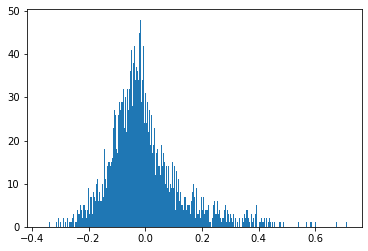

In [7]:
plt.hist(list(map(lambda x: x.metric, Clique.create_cliques(edge_combo, td_mean))), bins=1000);

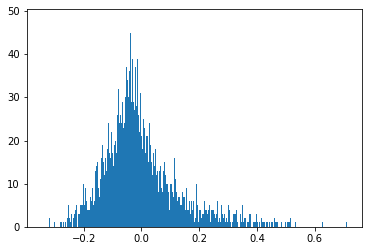

In [8]:
plt.hist(list(map(lambda x: x.metric, Clique.create_cliques(edge_combo, asd_mean))), bins=1000);

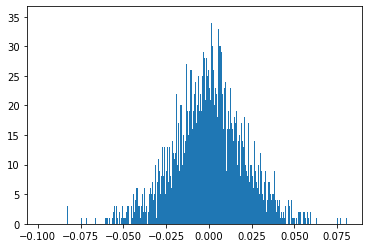

In [9]:
plt.hist(list(map(lambda x: x.metric, td_asd_edges)), bins=1000);

In [10]:
td_degrees = np.sum(td_positive_mean, axis=0)
asd_degrees = np.sum(asd_positive_mean, axis=0)

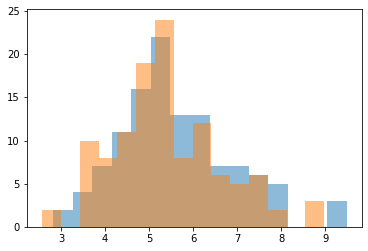

In [11]:
plt.hist(td_degrees, bins=15, alpha=.5);
plt.hist(asd_degrees, bins=15, alpha=.5);

In [12]:
seed = 50

In [13]:
td_ci, td_q = modularity.modularity_louvain_und_sign(td_mean, qtype='sta', seed=3)

print('positive edges:')
measure_edge_weight(td_ci, td_positive_mean, edge_combo)

print('\nnegative edges:')
measure_edge_weight(td_ci, td_negative_mean, edge_combo)

positive edges:
# of inter-edges: 1352; # of intra-edges: 1284
inter-edge ratio: 0.2976; intra-edge ratio: 0.7024
total inter-edge weight: 97.0033; total intra-edge weight: 228.9003

negative edges:
# of inter-edges: 3795; # of intra-edges: 239
inter-edge ratio: 0.9596; intra-edge ratio: 0.0404
total inter-edge weight: -311.9546; total intra-edge weight: -13.1275


In [24]:
count = 0
td_inter_edges = []
td_intra_edges = []
td_inter_edges_inclusion = []
td_freq_dict = {}
for i, e_idx in enumerate(sorted_edge_indices[:500]):
    e = td_asd_edges[e_idx].vertices

    path = (td_ci[e[0]], td_ci[e[1]])
    if path[0] > path[1]:
        path = (path[1], path[0])
    
    if td_ci[e[0]] != td_ci[e[1]]:
        if td_freq_dict.get(path) is None:
            td_freq_dict[path] = 0
        
        count += 1
        if td_mean[e] > 0:
            td_freq_dict[path] += td_mean[e]
            print(f'{i}, {td_asd_edges[e_idx]}, {(td_ci[e[0]], td_ci[e[1]])}, {td_mean[e]:.3f}, {asd_mean[e]:.3f}, td v0 degree: {np.sum(td_positive_mean[e[0], :]):.3f}, td v1 degree: {np.sum(td_positive_mean[e[1], :]):.3f}')
        td_inter_edges.append(td_mean[e])
    else:
        td_intra_edges.append(td_mean[e])
        # print(f'{i}, {td_asd_edges[e_idx]}, {(asd_td_ci[e[0]], asd_td_ci[e[1]])}, {td_mean[e]:.3f}')
    td_inter_edges_inclusion.append(count / (i + 1))

td_inter_edges = np.array(td_inter_edges)
td_intra_edges = np.array(td_intra_edges)

td_freq_dict

2, (25, 110), 0.076, (2, 5), 0.190, 0.114, td v0 degree: 7.344, td v1 degree: 6.654
4, (27, 110), 0.074, (2, 5), 0.147, 0.073, td v0 degree: 7.090, td v1 degree: 6.654
8, (45, 85), 0.069, (3, 2), 0.004, -0.065, td v0 degree: 5.033, td v1 degree: 3.700
17, (24, 110), 0.060, (2, 5), 0.142, 0.082, td v0 degree: 6.266, td v1 degree: 6.654
22, (9, 11), 0.059, (2, 1), 0.179, 0.120, td v0 degree: 4.928, td v1 degree: 5.265
23, (52, 61), 0.058, (3, 1), 0.144, 0.086, td v0 degree: 4.309, td v1 degree: 5.433
26, (31, 110), 0.058, (2, 5), 0.029, -0.029, td v0 degree: 6.702, td v1 degree: 6.654
30, (77, 92), 0.057, (4, 5), 0.026, -0.031, td v0 degree: 5.593, td v1 degree: 6.131
43, (30, 110), 0.053, (2, 5), 0.014, -0.039, td v0 degree: 6.237, td v1 degree: 6.654
45, (2, 93), 0.053, (2, 5), 0.219, 0.166, td v0 degree: 6.067, td v1 degree: 6.446
53, (10, 14), 0.051, (1, 2), 0.360, 0.309, td v0 degree: 4.817, td v1 degree: 5.901
56, (50, 89), 0.051, (3, 2), 0.066, 0.015, td v0 degree: 4.848, td v1 de

{(2, 5): 4.2327432024943175,
 (2, 3): 0.9414783860004449,
 (1, 2): 2.2432785078986996,
 (1, 3): 0.9240345271569277,
 (4, 5): 1.0467769685333053,
 (2, 4): 1.5693315793071023,
 (1, 4): 2.8161405061863936,
 (3, 4): 0.6110369296620519,
 (1, 5): 0.08063637816139642}

In [15]:
np.sum(td_inter_edges < 0), np.sum(td_inter_edges > 0), len(td_inter_edges), np.sum(td_intra_edges < 0), np.sum(td_intra_edges > 0), len(td_intra_edges)

(127, 168, 295, 12, 193, 205)

In [16]:
np.sum(td_inter_edges[td_inter_edges < 0]), np.sum(td_inter_edges[td_inter_edges > 0]), np.sum(td_intra_edges[td_intra_edges < 0]), np.sum(td_intra_edges[td_intra_edges > 0])

(-6.278125274860848,
 14.465456985400639,
 -0.7612184118408833,
 44.12343084050685)

In [23]:
count = 0
asd_inter_edges = []
asd_intra_edges = []
asd_inter_edges_inclusion = []
asd_freq_dict = {}

for i, e_idx in enumerate(reversed(sorted_edge_indices[-500:])):
    e = td_asd_edges[e_idx].vertices

    path = (td_ci[e[0]], td_ci[e[1]])
    if path[0] > path[1]:
        path = (path[1], path[0])
    
    if td_ci[e[0]] != td_ci[e[1]]:
        if asd_freq_dict.get(path) is None:
            asd_freq_dict[path] = 0
        count += 1
        if asd_mean[e] > 0:
            asd_freq_dict[path] += asd_mean[e]
            print(f'{i}, {td_asd_edges[e_idx]}, {(td_ci[e[0]], td_ci[e[1]])}, {td_mean[e]:.3f}, {asd_mean[e]:.3f}, asd v0 degree: {np.sum(asd_positive_mean[e[0], :]):.3f}, asd v1 degree: {np.sum(asd_positive_mean[e[1], :]):.3f}')
        asd_inter_edges.append(asd_mean[e])
    else:
        asd_intra_edges.append(asd_mean[e])
        # print(f'{i}, {td_asd_edges[e_idx]}, {(asd_td_ci[e[0]], asd_td_ci[e[1]])}, {td_mean[e]:.3f}')
    asd_inter_edges_inclusion.append(count / (i + 1))

asd_inter_edges = np.array(asd_inter_edges)
asd_intra_edges = np.array(asd_intra_edges)

asd_freq_dict

1, (77, 85), -0.094, (4, 2), -0.083, 0.010, asd v0 degree: 5.583, asd v1 degree: 3.728
5, (13, 30), -0.084, (1, 2), -0.061, 0.022, asd v0 degree: 5.159, asd v1 degree: 6.219
7, (13, 31), -0.083, (1, 2), -0.026, 0.057, asd v0 degree: 5.159, asd v1 degree: 6.323
9, (12, 30), -0.083, (1, 2), -0.042, 0.041, asd v0 degree: 4.770, asd v1 degree: 6.219
17, (76, 84), -0.068, (4, 2), -0.031, 0.037, asd v0 degree: 7.164, asd v1 degree: 4.598
20, (76, 85), -0.066, (4, 2), -0.062, 0.004, asd v0 degree: 7.164, asd v1 degree: 3.728
21, (37, 85), -0.066, (4, 2), 0.065, 0.131, asd v0 degree: 7.227, asd v1 degree: 3.728
34, (89, 105), -0.059, (2, 5), -0.040, 0.018, asd v0 degree: 4.217, asd v1 degree: 4.454
43, (30, 70), -0.056, (2, 4), 0.181, 0.236, asd v0 degree: 6.219, asd v1 degree: 4.475
50, (73, 85), -0.055, (4, 2), -0.018, 0.037, asd v0 degree: 7.328, asd v1 degree: 3.728
51, (28, 30), -0.054, (4, 2), 0.159, 0.214, asd v0 degree: 8.753, asd v1 degree: 6.219
53, (54, 88), -0.054, (3, 2), 0.165, 0

{(2, 4): 4.042320461914259,
 (1, 2): 1.157648329918898,
 (4, 5): 0.4592014516219413,
 (2, 3): 0.6478011204405649,
 (2, 5): 0.26369041866120546,
 (3, 5): 2.112387982228317,
 (1, 3): 0.23359321388362056,
 (1, 4): 0.3774401240123482,
 (1, 5): 0,
 (3, 4): 0.7948344714411018}

In [18]:
np.sum(asd_inter_edges < 0), np.sum(asd_inter_edges > 0), len(asd_inter_edges), np.sum(asd_intra_edges < 0), np.sum(asd_intra_edges > 0), len(asd_intra_edges)

(281, 122, 403, 9, 88, 97)

In [19]:
np.sum(asd_inter_edges[asd_inter_edges < 0]), np.sum(asd_inter_edges[asd_inter_edges > 0]), np.sum(asd_intra_edges[asd_intra_edges < 0]), np.sum(asd_intra_edges[asd_intra_edges > 0])

(-29.040146165384257,
 10.088917574122256,
 -0.2806215079491956,
 16.077727122557917)

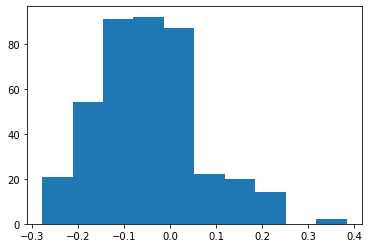

In [21]:
plt.hist(asd_inter_edges);

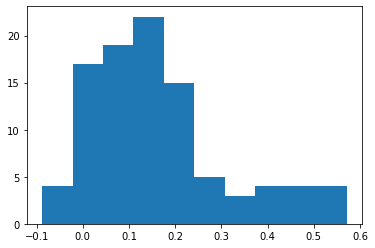

In [22]:
plt.hist(asd_intra_edges);

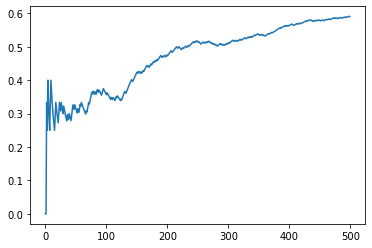

In [ ]:
plt.plot(inter_edges_inclusion);

In [ ]:
asd_ci, asd_q = modularity.modularity_louvain_und_sign(asd_mean, qtype='sta', seed=seed)

print('negative edges:')
measure_edge_weight(asd_ci, td_mean * (td_mean < 0), edge_combo)

print('\npositive edges:')
measure_edge_weight(asd_ci, td_mean * (td_mean > 0), edge_combo)

In [ ]:
count = 0
inter_edges = []
intra_edges = []
inter_edges_inclusion = []
for i, e_idx in enumerate(reversed(sorted_edge_indices[-500:])):
    e = td_asd_edges[e_idx].vertices
    
    if asd_ci[e[0]] != asd_ci[e[1]]:
        count += 1
        # if asd_mean[e] > 0:
        print(f'{i}, {td_asd_edges[e_idx]}, {(asd_ci[e[0]], asd_ci[e[1]])}, {asd_mean[e]:.3f}, {td_mean[e]:.3f}')
        inter_edges.append(asd_mean[e])
    else:
        intra_edges.append(asd_mean[e])
        # print(f'{i}, {td_asd_edges[e_idx]}, {(asd_td_ci[e[0]], asd_td_ci[e[1]])}, {td_mean[e]:.3f}')
    inter_edges_inclusion.append(count / (i + 1))

inter_edges = np.array(inter_edges)
intra_edges = np.array(intra_edges)

np.sum(inter_edges < 0), np.sum(inter_edges > 0), len(inter_edges), np.sum(intra_edges < 0), np.sum(intra_edges > 0), len(intra_edges)

1, (77, 85), -0.094, (2, 1), 0.010, -0.083
2, (77, 84), -0.089, (2, 1), -0.015, -0.104
6, (61, 67), -0.084, (1, 3), -0.019, -0.103
15, (57, 92), -0.069, (2, 3), -0.151, -0.220
17, (76, 84), -0.068, (2, 1), 0.037, -0.031
20, (76, 85), -0.066, (2, 1), 0.004, -0.062
21, (37, 85), -0.066, (2, 1), 0.131, 0.065
28, (57, 90), -0.060, (2, 3), -0.042, -0.102
34, (89, 105), -0.059, (1, 3), 0.018, -0.040
41, (22, 72), -0.056, (1, 2), -0.182, -0.238
43, (30, 70), -0.056, (1, 2), 0.236, 0.181
46, (34, 80), -0.055, (3, 2), -0.095, -0.150
48, (27, 29), -0.055, (1, 2), -0.233, -0.288
50, (73, 85), -0.055, (2, 1), 0.037, -0.018
51, (28, 30), -0.054, (2, 1), 0.214, 0.159
52, (57, 91), -0.054, (2, 3), -0.088, -0.142
53, (54, 88), -0.054, (3, 1), 0.219, 0.165
54, (24, 28), -0.054, (1, 2), -0.106, -0.160
56, (24, 72), -0.054, (1, 2), -0.115, -0.169
59, (39, 89), -0.053, (2, 1), 0.189, 0.137
60, (56, 92), -0.053, (2, 3), -0.152, -0.205
63, (24, 29), -0.052, (1, 2), -0.131, -0.183
64, (45, 60), -0.052, (3, 1

(210, 78, 288, 80, 132, 212)

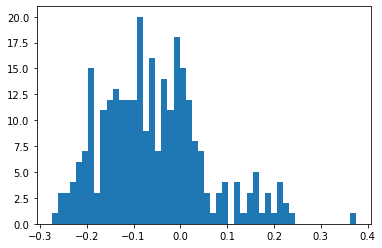

In [ ]:
plt.hist(inter_edges, bins=50);

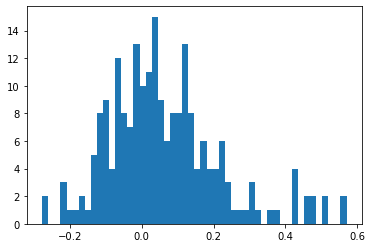

In [ ]:
plt.hist(intra_edges, bins=50);

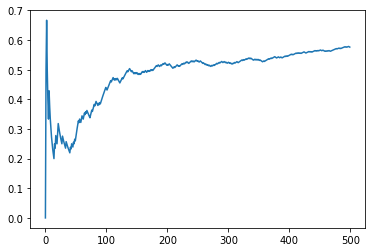

In [ ]:
plt.plot(inter_edges_inclusion)